In [6]:
import time
import os
import subprocess
import cv2
import moviepy
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Converting to grayscale

In [7]:
import os
import cv2

def convert_images_to_grayscale():
    base_data_path = "../data"
    images_path = os.path.join(base_data_path, "images")
    videos_path = os.path.join(base_data_path, "videos")
    gray_images_path = os.path.join(base_data_path, "gray_images")

    os.makedirs(gray_images_path, exist_ok=True)

    def process_folder(source_folder, prefix):
        """ Convert all images in source_folder to grayscale and save to gray_images_path with prefix """
        for experiment in os.listdir(source_folder):
            experiment_path = os.path.join(source_folder, experiment)
            if not os.path.isdir(experiment_path):
                continue  # Skip non-folder entries

            # Create grayscale output folder
            gray_experiment_folder = os.path.join(gray_images_path, f"{prefix}_{experiment}")
            os.makedirs(gray_experiment_folder, exist_ok=True)

            # Process each file
            for file in os.listdir(experiment_path):
                file_path = os.path.join(experiment_path, file)
                if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".ppm")):  # Ensure ppm is included
                    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # Read as is
                    if img is None:
                        print(f"Skipping unreadable file: {file_path}")
                        continue  

                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    output_path = os.path.join(gray_experiment_folder, file)
                    cv2.imwrite(output_path, gray_img)

    # Process both folders
    process_folder(images_path, "images")
    process_folder(videos_path, "videos")

    print("All images converted to grayscale and saved in data/gray_images.")

# Run the function
convert_images_to_grayscale()


All images converted to grayscale and saved in data/gray_images.


[ERROR:0@47.540] global loadsave.cpp:912 imwrite_ imwrite_('../data/gray_images/images_test_2/reference.ppm'): can't write data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/grfmt_pxm.cpp:433: error: (-5:Bad argument) Portable bitmap(.ppm) expects BGR image in function 'write'

[ERROR:0@47.546] global loadsave.cpp:912 imwrite_ imwrite_('../data/gray_images/images_test_3/reference.ppm'): can't write data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/grfmt_pxm.cpp:433: error: (-5:Bad argument) Portable bitmap(.ppm) expects BGR image in function 'write'

[ERROR:0@47.551] global loadsave.cpp:912 imwrite_ imwrite_('../data/gray_images/images_test_1/reference.ppm'): can't write data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/grfmt_pxm.cpp:433: error: (-5:Bad argument) Portable bitmap(.ppm) expects BGR image in function 'write'

[ERROR:0@47.555] global loadsave.cpp:912 imwrite_ imwrite_('../data/gray_images/videos_test_2/reference.ppm'): can't write data: OpenCV(4.11.0) /io/opencv

# Getting a df

In [11]:
def get_df_image_info():
    base_path = "../data/gray_images/"
    image_formats = ["bmp", "jpg", "png"]
    test_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    data = []

    for folder_name in test_folders:
        folder_path = os.path.join(base_path, folder_name)

        ref_img_path = os.path.join(folder_path, "output.jpg")
        ref_img = cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE)

        # if ref_img == None:
        #     continue
        
        for fmt in image_formats:
            file_path = os.path.join(folder_path, f"output.{fmt}")
            compare_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if compare_img is not None:
                # Resize to match reference if needed
                compare_img = cv2.resize(compare_img, (ref_img.shape[1], ref_img.shape[0]))

                # Compute SSIM
                ssim_score = ssim(ref_img, compare_img)
                
                # Compute Mean Squared Error (MSE)
                mse_score = np.mean((ref_img.astype("float") - compare_img.astype("float")) ** 2)

            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path) / 1024  # Convert to KB
                img = cv2.imread(file_path)
                if img is not None:
                    height, width = img.shape[:2]
                image_size = f"{width}x{height}"  # Known capture resolution
                data.append([folder_name, fmt.upper(), image_size, f"{file_size:.2f} KB", round(ssim_score, 4), round(mse_score, 4)])

    # Create a global DataFrame
    df = pd.DataFrame(data, columns=["Test Folder", "Format", "Resolution", "File Size", "SSIM", "MSE"])
    return df

df = get_df_image_info()
df.head(10)

[ WARN:0@158.824] global loadsave.cpp:268 findDecoder imread_('../data/gray_images/videos_test_1/output.bmp'): can't open/read file: check file path/integrity
[ WARN:0@158.861] global loadsave.cpp:268 findDecoder imread_('../data/gray_images/videos_test_1/output.png'): can't open/read file: check file path/integrity
[ WARN:0@158.862] global loadsave.cpp:268 findDecoder imread_('../data/gray_images/videos_test_2/output.bmp'): can't open/read file: check file path/integrity
[ WARN:0@158.899] global loadsave.cpp:268 findDecoder imread_('../data/gray_images/videos_test_2/output.png'): can't open/read file: check file path/integrity


,Test Folder,Format,Resolution,File Size,SSIM,MSE
0,images_test_1,BMP,352x288,100.05 KB,0.9998,0.0124
1,images_test_1,JPG,352x288,3.49 KB,1.0000,0.0000
2,images_test_1,PNG,352x288,12.84 KB,0.9998,0.0124
3,images_test_2,BMP,352x288,100.05 KB,0.9998,0.0105
4,images_test_2,JPG,352x288,3.10 KB,1.0000,0.0000
5,images_test_2,PNG,352x288,11.19 KB,0.9998,0.0105
6,images_test_3,BMP,352x288,100.05 KB,0.9998,0.0086
7,images_test_3,JPG,352x288,3.12 KB,1.0000,0.0000
8,images_test_3,PNG,352x288,11.18 KB,0.9998,0.0086
9,videos_test_1,JPG,640x360,25.16 KB,1.0000,0.0000


# Visualisation

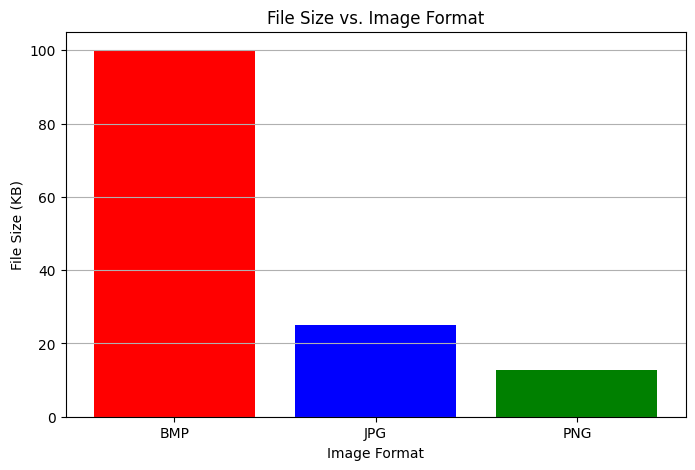

In [12]:
plt.figure(figsize=(8, 5))
plt.bar(df["Format"], df["File Size"].str.replace(" KB", "").astype(float), color=["red", "blue", "green"])
plt.xlabel("Image Format")
plt.ylabel("File Size (KB)")
plt.title("File Size vs. Image Format")
plt.grid(axis="y")
plt.show()

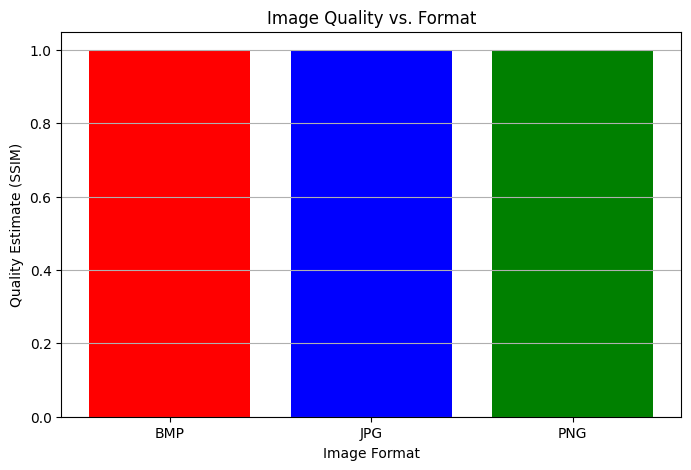

In [13]:
plt.figure(figsize=(8, 5))
plt.bar(df["Format"], df["SSIM"], color=["red", "blue", "green"])
plt.xlabel("Image Format")
plt.ylabel("Quality Estimate (SSIM)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.show()

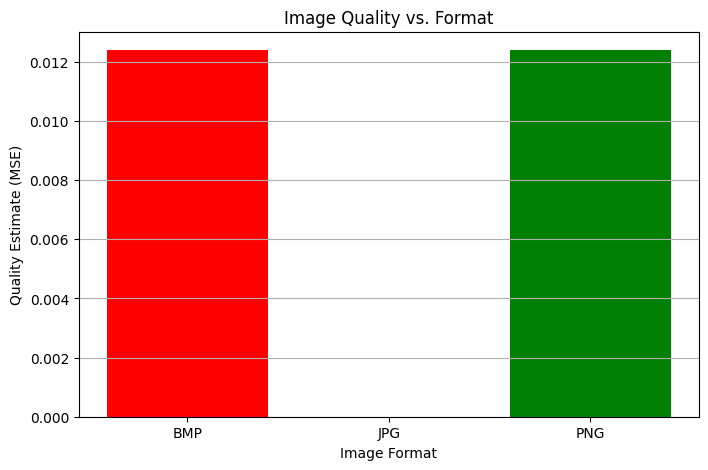

In [14]:
plt.figure(figsize=(8, 5))
plt.bar(df["Format"], df["MSE"], color=["red", "blue", "green"])
plt.xlabel("Image Format")
plt.ylabel("Quality Estimate (MSE)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.show()